In [1]:
##### import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
import glob
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from features import *
from sklearn import preprocessing
from scipy.ndimage.measurements import label


In [2]:
### Data paths
datapath = '../Data/'
files_path = datapath +'*/*/*.png'
test_imgs_path = '../test_images/*.jpg'
files_names = glob.glob(files_path) 
test_imgs_files = glob.glob(test_imgs_path)

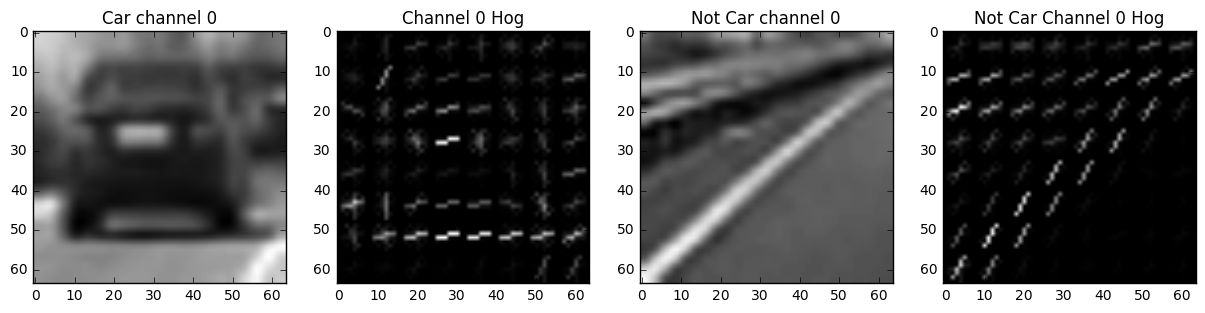

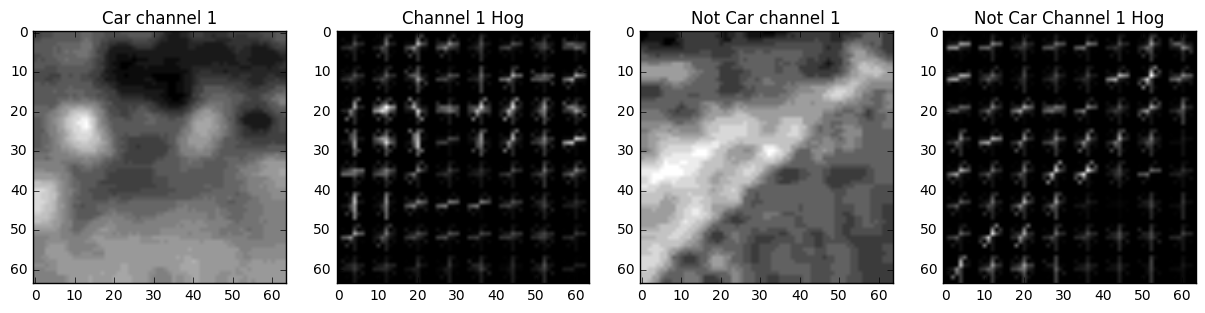

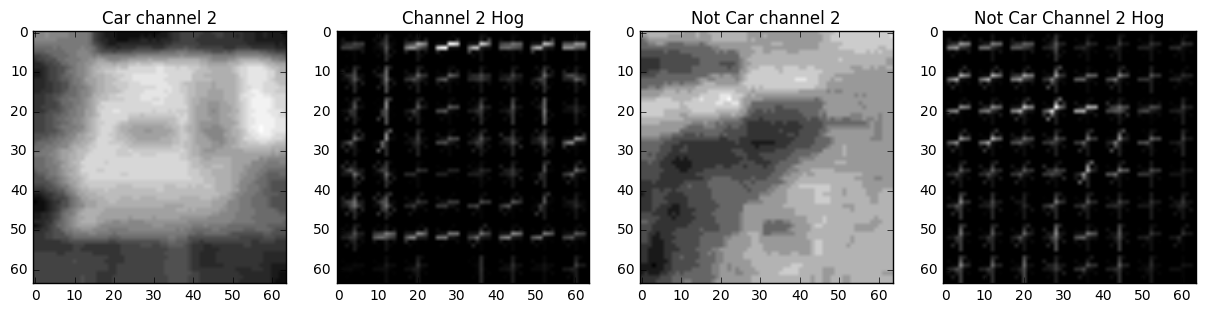

In [20]:
car = cv2.imread('../Data/vehicles/GTI_Far/image0000.png')
car = cv2.cvtColor(car,cv2.COLOR_BGR2YCrCb)
nocar = cv2.imread('../Data/non-vehicles/GTI/image13.png')
nocar = cv2.cvtColor(nocar,cv2.COLOR_BGR2YCrCb)
for ch in range(car.shape[2]):
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (15,20))
    _,hog_car = get_hog_features(car[:,:,ch],vis = True , feature_vec = True)
    _,hog_nocar = get_hog_features(nocar[:,:,ch],vis = True , feature_vec = True)

    ax1.imshow(car[:,:,ch],cmap = 'gray')
    ax2.imshow(hog_car , cmap ='gray')
    ax3.imshow(nocar[:,:,ch],cmap = 'gray')
    ax4.imshow(hog_nocar , cmap ='gray')
    ax1.set_title('Car channel ' +str(ch))
    ax2.set_title('Channel '+str(ch)+' Hog')
    ax3.set_title('Not Car channel ' +str(ch))
    ax4.set_title('Not Car Channel '+str(ch)+' Hog')

    plt.show()

In [3]:
#######Extract features from image files
load_old_features = True
data = []
if(load_old_features):
    data = pickle.load(open('Data.p','rb'))
else:
    data = extract_features(files_names, color_space='YCrCb', spatial_size=(32, 32),
                            hist_bins=32, orient=9,
                            pix_per_cell=8, cell_per_block=2, hog_channel = 'ALL',
                            spatial_feat=True, hist_feat=True, hog_feat=True)

In [4]:
#Load features
X = data['data']
y = data['labels']

In [5]:
concat = np.hstack((X,np.expand_dims(y,axis = 1))) ## for shuffling
np.random.shuffle(concat)
X = concat[:,:-1]
y = concat[:,-1]

In [6]:
##Compute Data statistics
scaler  = preprocessing.StandardScaler().fit(X)


In [7]:
###normalize data 
X = scaler.transform(X)

In [8]:
####Train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print('Training samples: ',X_train.shape)
print('Test samples: ',X_test.shape)

Training samples:  (14208, 8460)
Test samples:  (3552, 8460)


In [9]:
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
use_old_classifier = False
if(not use_old_classifier):
#     clf = SVC(C = 1.0,kernel = 'rbf')
    clf = LinearSVC(C=0.1)
    clf.fit(X_train,y_train)
    print('Finished Training')
    joblib.dump(clf, 'classifier.pkl') 
    joblib.dump(scaler, 'scaler.pkl')
else:
    clf = joblib.load('classifier.pkl')
    scaler = joblib.load('scaler.pkl')

Finished Training


In [10]:
train_acc = clf.score(X_train,y_train)
test_acc = clf.score(X_test,y_test)
print('Training accuracy: ',train_acc)
print('Testing accuracy: ',test_acc)

Training accuracy:  1.0
Testing accuracy:  0.993806306306


In [11]:
#Takes an image returns bounding boxes
def find_cars(img,scale =1.5):
    draw = np.copy(img)
    draw2 = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    scaled_img = img
    ytop = int(img.shape[0]//2)
    scaled_img = scaled_img[ytop:,:,:]
    imshape = scaled_img.shape
    if scale != 1:
        scaled_img = cv2.resize(scaled_img , (int(imshape[1]/scale),int(imshape[0]/scale)))
        imshape = scaled_img.shape
    scaled_img = transform_color(scaled_img, space = 'YCrCb')
    
    window = 64
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    feat_per_block = orient * cell_per_block**2
    nx_blocks = (imshape[1] // pix_per_cell) - 1
    ny_blocks = (imshape[0] // pix_per_cell) - 1
    nblocks_per_window = (window // pix_per_cell) - 1
    block_per_step = 2 # 75 % overlap
    xstep = (nx_blocks - nblocks_per_window) // block_per_step
    ystep = (ny_blocks - nblocks_per_window) // block_per_step
    
    Hog_features = hog_features(scaled_img,orient,pix_per_cell , cell_per_block , feature_vec = False , channel = 'ALL')
    hog_ch1 = Hog_features[0]
    hog_ch2 = Hog_features[1]
    hog_ch3 = Hog_features[2]
    temp =[]
    cnt = 0
    total_cnt =0
    for x in range(xstep):
        for y in range(ystep):
            x_start = x*block_per_step
            y_start = y*block_per_step
            hog_feat1 = hog_ch1[y_start:y_start+nblocks_per_window,x_start:x_start+nblocks_per_window].ravel()
            hog_feat2 = hog_ch2[y_start:y_start+nblocks_per_window,x_start:x_start+nblocks_per_window].ravel()
            hog_feat3 = hog_ch3[y_start:y_start+nblocks_per_window,x_start:x_start+nblocks_per_window].ravel()
            Hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            x_top = x_start * pix_per_cell
            y_top = y_start * pix_per_cell
            
            img_patch = scaled_img[y_top:y_top+window,x_top:x_top+window,:]
            
            spatial_features = compress_spatially(img_patch)
            color_features = color_histogram(img_patch)
            features = np.concatenate((spatial_features,color_features,Hog_features))
            features = np.expand_dims(features,axis = 0)
            features = scaler.transform(features)
            temp = img_patch.shape            
            pred = clf.predict(features)
            total_cnt +=1
            if(pred == 1 ):
                cnt+=1
                x_orig = int(x_top * scale)
                y_orig = int(y_top * scale)
                window_orig = int(window * scale)
                heatmap[y_orig+ytop:y_orig+ytop+window_orig,x_orig:x_orig+window_orig] += 1
                cv2.rectangle(draw,(x_orig , y_orig+ytop),(x_orig+window_orig,y_orig+ytop+window_orig),(255,0,0),6)
#                 rgb = cv2.cvtColor(img_patch,cv2.COLOR_HSV2RGB)
#                 plt.imshow(rgb)
#                 plt.show()

    return draw , heatmap            
#     print('Number of windows:', xstep*ystep)

def heatmap_threshold(heatmap,threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap
    
def draw_labeled_boxes(img,labels):
    for car in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        max_x = np.max(nonzerox) 
        min_x = np.min(nonzerox)
        max_y = np.max(nonzeroy)
        min_y = np.min(nonzeroy)
        if( (max_x - min_x >55) and (max_y - min_y > 55) ):
            bbox = ((min_x, min_y), (max_x, max_y))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
#             print('width:',max_x-min_x,' height:',max_y-min_y)
    # Return the image
    return img

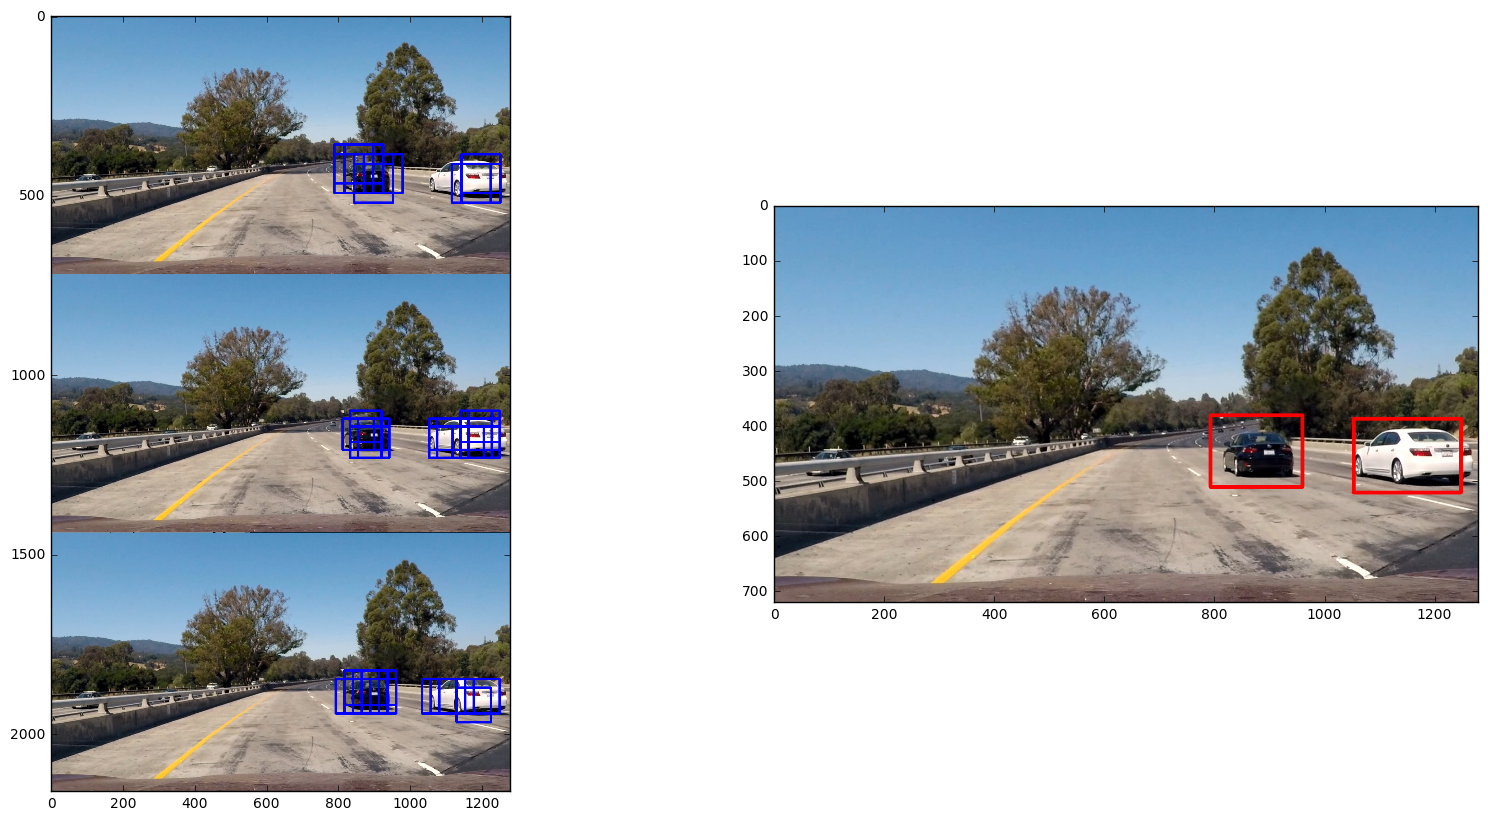

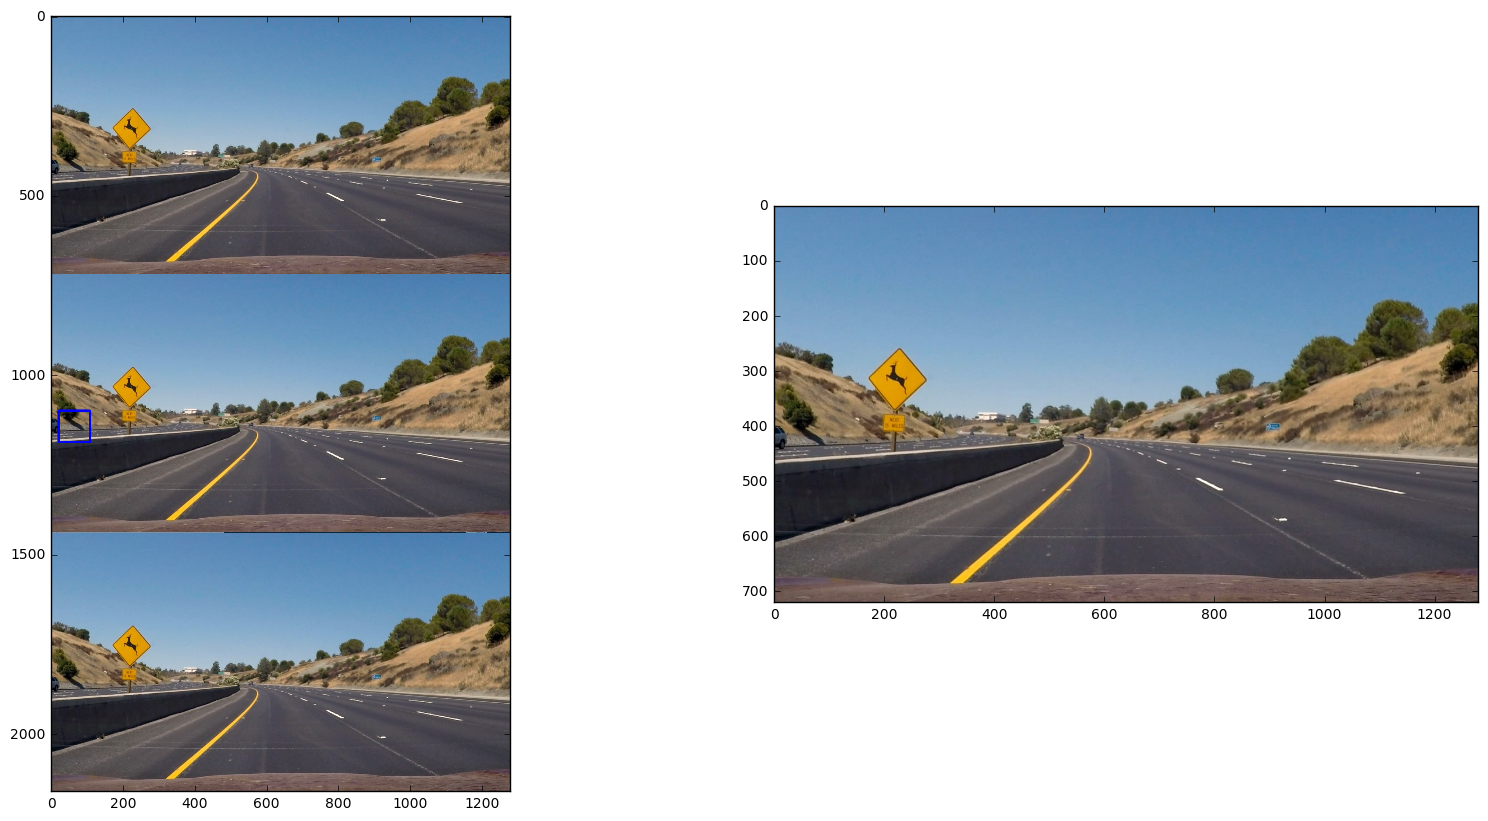

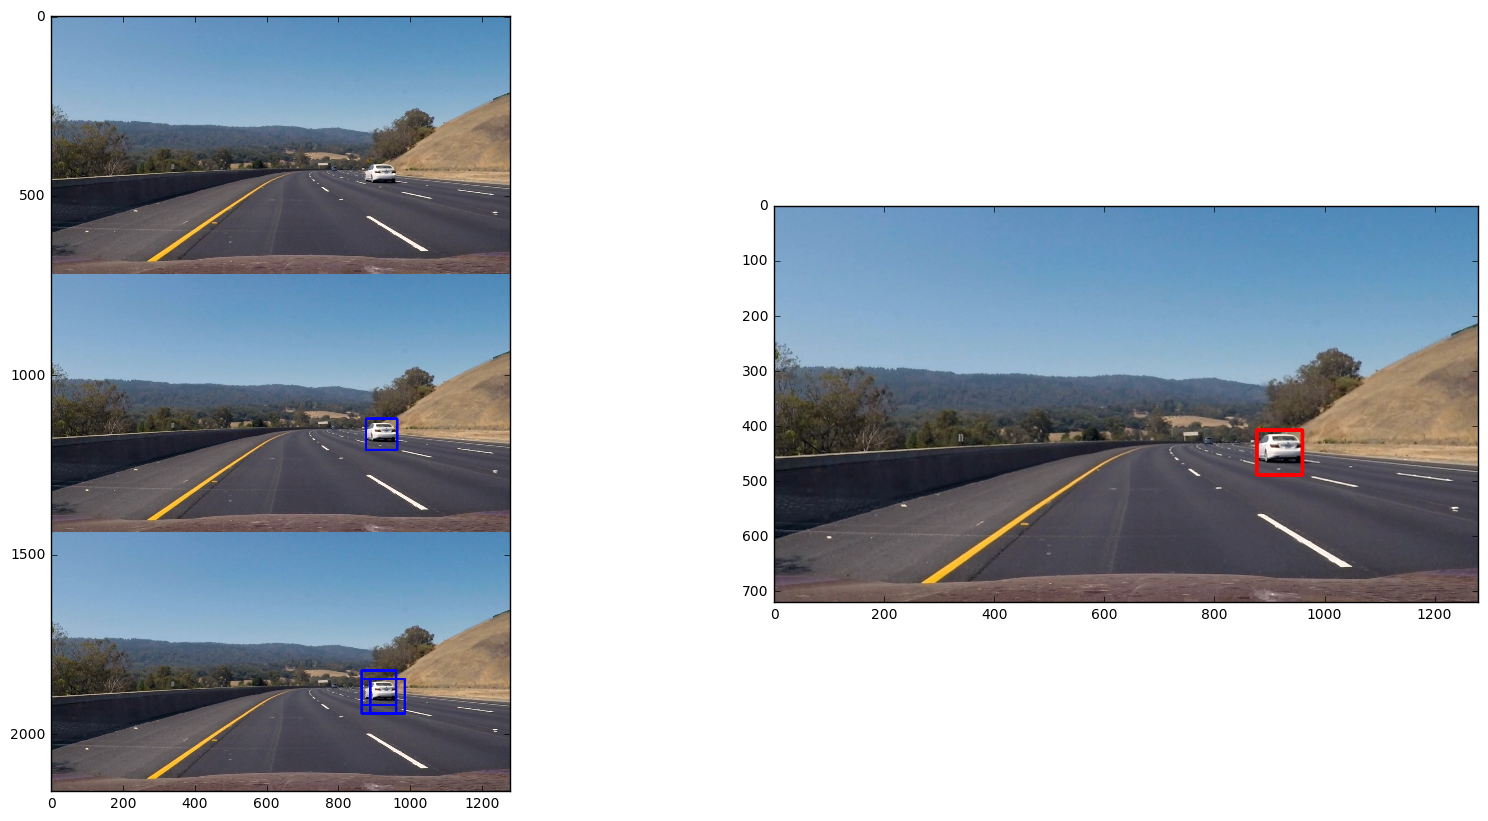

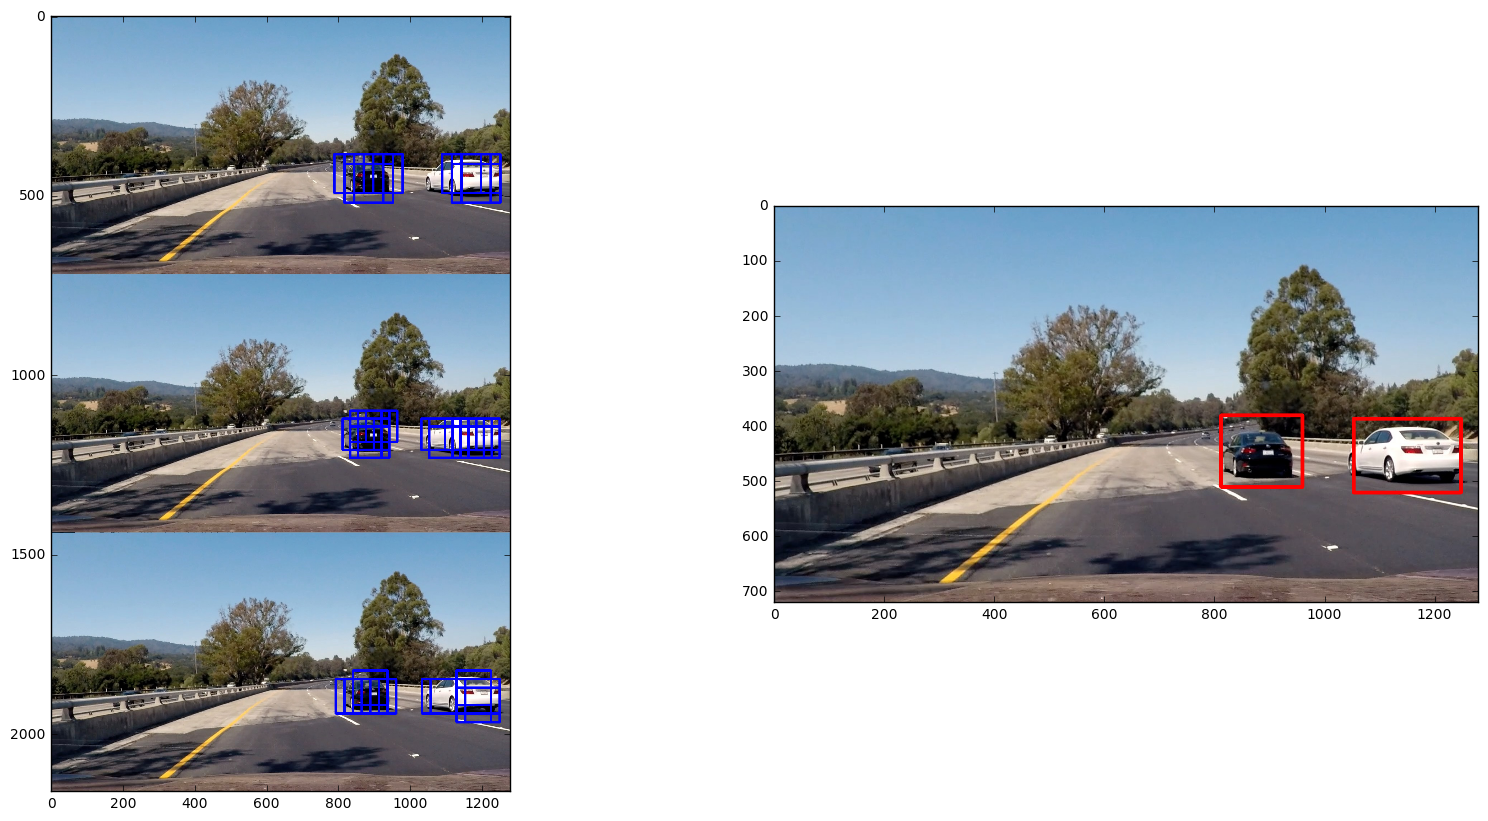

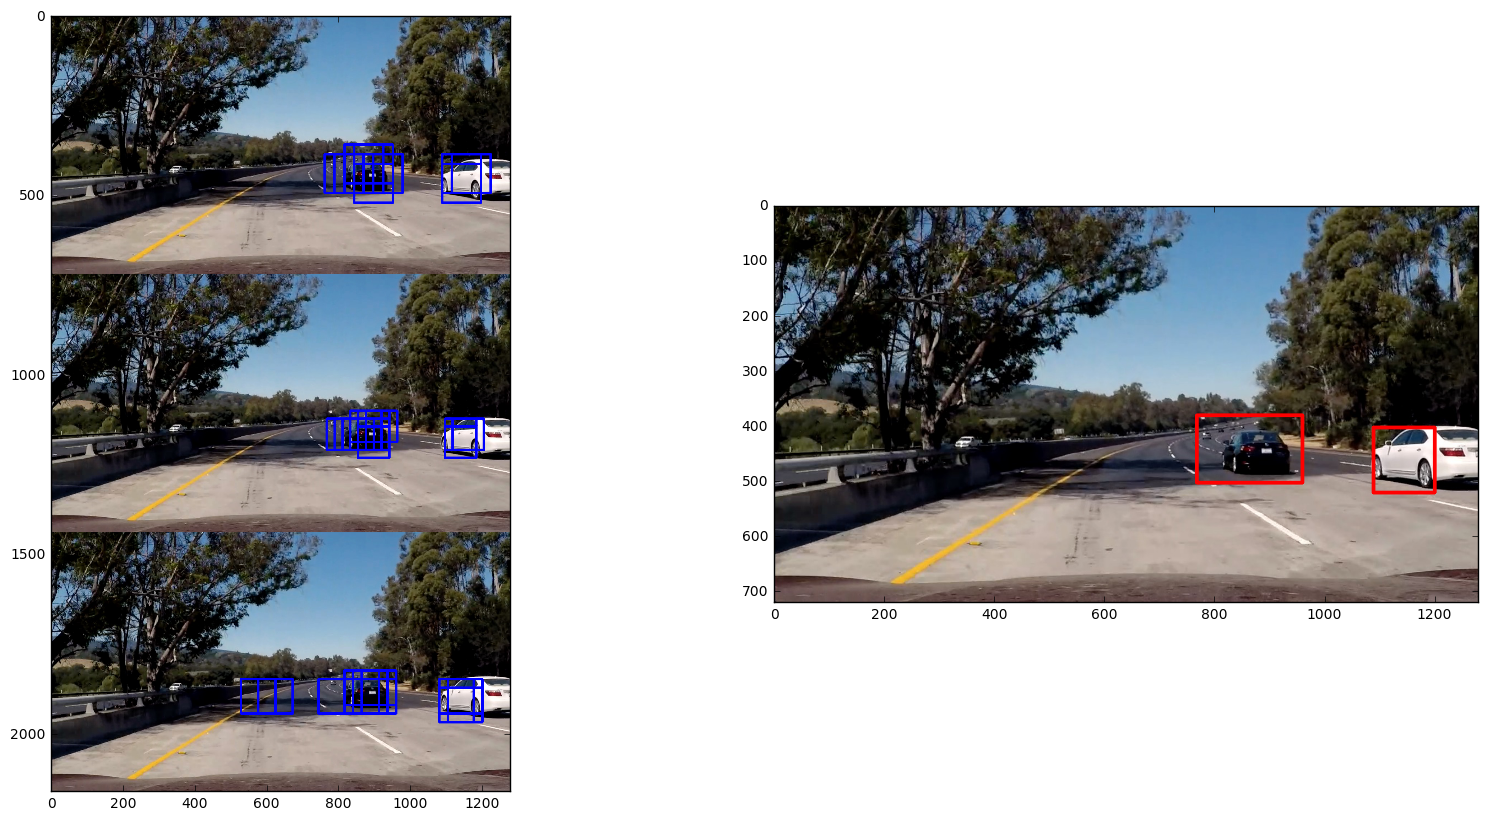

In [ ]:
for file in test_imgs_files:
    image = cv2.imread(file)
    final_out = np.copy(image)
    detected_windows = []
    corrected_windows = np.zeros_like(image[:,:,0])

    draw , heatmap = find_cars(image , scale = 1.7)
    detected_windows.append(draw)
    corrected_windows = heatmap
#     draw , heatmap = find_cars(image , scale = 1.63)
#     detected_windows.append(draw)
#     corrected_windows += heatmap
    draw , heatmap = find_cars(image , scale = 1.37)
    detected_windows.append(draw)
    corrected_windows += heatmap
    draw , heatmap = find_cars(image , scale = 1.5)
    detected_windows.append(draw)
    corrected_windows += heatmap
    detected_windows = np.concatenate(detected_windows)

    heatmap = heatmap_threshold(corrected_windows , threshold = 2)
    labels = label(heatmap)
    final_out = draw_labeled_boxes(final_out,labels)

    f,(ax1,ax2) = plt.subplots(1,2,figsize =(20,10))
    ax1.imshow(cv2.cvtColor(detected_windows,cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(final_out,cv2.COLOR_BGR2RGB))
    # ax2.imshow(heatmap , cmap = 'hot')
    plt.show()
    

In [ ]:
buffer_size = 10
cumulative_heat = np.zeros((buffer_size,720,1280))
nFrames = 0
def process_image(image):
    global cumulative_heat
    global nFrames
    global buffer_size
    frame_heat =[]
    alpha = 0.6
    beta = 0.4

    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    final_out = np.copy(image)

    _ , heatmap = find_cars(image , scale = 1.35)
    frame_heat =  heatmap
    _ , heatmap = find_cars(image , scale = 1.7)
    frame_heat += heatmap
#     _ , heatmap = find_cars(image , scale = 1.45)
#     frame_heat += heatmap
    _ , heatmap = find_cars(image , scale = 1.5)
    frame_heat += heatmap
    
#     cumulative_heat = alpha * cumulative_heat + beta * frame_heat
    heatmap  = beta * frame_heat + alpha * np.mean(cumulative_heat,axis = 0)
#     heatmap = cumulative_heat    
    heatmap = heatmap_threshold(heatmap , threshold = 2.5)
    cumulative_heat[nFrames] = frame_heat

    nFrames = (nFrames + 1) % buffer_size
    labels = label(heatmap)
    final_out = draw_labeled_boxes(final_out,labels)
    final_out = cv2.cvtColor(final_out,cv2.COLOR_BGR2RGB)
    return final_out

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
out_video = 'out.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(out_video, audio=False)